# Mixture Density Network (dependent)
Each output dimension has dependent mixtures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from util import suppress_tf_warning,get_vars,gpu_sess,NormalizerClass,get_mdn_training_data
suppress_tf_warning()
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("TF version:[%s]."%(tf.__version__))

TF version:[1.15.0].


### MDN Class

In [2]:
tfd = tf.contrib.distributions
tfrni = tf.random_normal_initializer
tfci = tf.constant_initializer
tfrui = tf.random_uniform_initializer

class MixtureDensityNetworkClass(object):
    """
    Mixture density network with independent output
    """
    def __init__(self,name='MDN',x_dim=1,y_dim=2,k=5,h_dims=[32,32],actv=tf.nn.tanh,sig_max=0):
        """
        Initialize
        """
        self.name = name
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.k = k # number of mixtures
        self.h_dims = h_dims
        self.actv = actv
        self.sig_max = sig_max
        
        self.build_model()
        self.build_graph()
        
    def build_model(self):
        """
        Build model
        """
        self.ph_x = tf.placeholder(dtype=tf.float32,shape=[None,self.x_dim],name='x')
        self.ph_y = tf.placeholder(dtype=tf.float32,shape=[None,self.y_dim],name='y')
        
        with tf.variable_scope(self.name,reuse=False):
            net = self.ph_x
            for h_idx,h_dim in enumerate(self.h_dims):
                net = tf.layers.dense(
                    net,h_dim,activation=self.actv,kernel_initializer=tfrni(stddev=0.01),
                    bias_initializer=tfci(value=0),name='hid_%d'%(h_idx))
            # Pi
            self.pi_logit = tf.layers.dense(
                net,self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                bias_initializer=tfci(value=0),name='pi')
            self.pi = tf.nn.softmax(self.pi_logit,axis=1)
            # Mu (bias_initializer is important!)
            mu_min,mi_max = -3,+3
            self.mu_raw = tf.layers.dense(
                net,self.y_dim*self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                bias_initializer=tfrui(minval=mu_min,maxval=mi_max),name='mu') # [N x y_dim*k]
            self.mu = tf.reshape(self.mu_raw,shape=(-1,self.y_dim,self.k)) # [N x y_dim x k]
            # Var
            self.log_var_raw = tf.layers.dense(
                net,self.y_dim*self.k,activation=None,kernel_initializer=tfrni(stddev=0.01),
                bias_initializer=tfci(0),name='logvar') # [N x y_dim*k]
            self.log_var = tf.reshape(self.log_var_raw,shape=(-1,self.y_dim,self.k)) # [N x y_dim x k]
            if self.sig_max == 0:
                self.var = tf.exp(self.log_var)
            else:
                self.var = self.sig_max*tf.sigmoid(self.log_var)
        self.tf_vars = get_vars(scope=self.name)
        
        
    def build_graph(self):
        """
        Build graph
        """
        # Basic GMM 
        self.cat = tfd.Categorical(probs=self.pi) # categorical r.v.
        self.comps = [tfd.MultivariateNormalDiag(loc=loc,scale_diag=tf.sqrt(scale))
                      for loc,scale in zip(tf.unstack(tf.transpose(self.mu,[2,0,1])),
                                           tf.unstack(tf.transpose(self.var,[2,0,1])))]
        self.tfd_mog = tfd.Mixture(cat=self.cat,components=self.comps) # mixture of Gaussian 
        self.log_liks = self.tfd_mog.log_prob(self.ph_y) # [n]
        self.log_lik = tf.reduce_mean(self.log_liks) # [1]
        # pi:[n x k] / mu:[n x d x k] / var:[n x d x k]
        
        # Uncertainty estimation 
        pi_axis = self.pi[:,:,tf.newaxis]
        self.EVs = tf.squeeze(tf.matmul(self.var,pi_axis),axis=2) # [n x y_dim]
        self.EV = tf.reduce_sum(self.EVs,axis=1) # [n]
        
        # Var[E[y]] - Epistemic 
        mu_average = tf.matmul(self.mu,self.pi[:,:,tf.newaxis]) # [n x y_dim x 1]
        mu_diff_sq = tf.square(self.mu-mu_average) # [n x y_dim x k]
        self.VEs = tf.squeeze(tf.matmul(mu_diff_sq,pi_axis),axis=2) # [n x y_dim]
        self.VE = tf.reduce_sum(self.VEs,axis=1) # [n]
        
        # Sampler
        self.y_sample = tf.squeeze(self.tfd_mog.sample(1),[0]) # [n x y_dim]
        
        # Optimizer
        self.c_vars = [var for var in self.tf_vars if '%s/'%(self.name) in var.name]
        self.l2_reg_coef = 1e-8
        self.l2_reg = self.l2_reg_coef*tf.reduce_sum(tf.stack([tf.nn.l2_loss(v) for v in self.c_vars])) # [1]
        self.cost = -self.log_lik + self.l2_reg # [1]
        self.optm = tf.train.RMSPropOptimizer(learning_rate=1e-3).minimize(self.cost)
        
    def update(self,sess,x_batch,y_batch):
        """
        Update
        """
        feeds = {self.ph_x:x_batch,self.ph_y:y_batch}
        cost_val,_ = sess.run([self.cost,self.optm],feed_dict=feeds)
        return cost_val
        
    def plot_test_result(self,sess,x_test,x_train=None,y_train=None,
                         fig_size=(15,5),wspace=0.1,hspace=0.05,pi_th=0.0,ylim=None,
                         title_str='Result',tfs=15):
        """
        Plot test result
        """
        feeds = {self.ph_x:x_test}
        y_sample = sess.run(self.y_sample,feed_dict=feeds) # [N x y_dim] 
        mu,var,pi = sess.run([self.mu,self.var,self.pi],feed_dict=feeds)
        # Plot per each output dimensions
        nr,nc = 1,self.y_dim
        if nc>2: nc=2 # Upper limit on the number of columns
        gs  = gridspec.GridSpec(nr,nc)
        gs.update(wspace=wspace,hspace=hspace)
        fig = plt.figure(figsize=fig_size)
        fig.suptitle(title_str,size=tfs)
        for i in range(nr*nc): # per each dimension
            ax = plt.subplot(gs[i])
            cmap = plt.get_cmap('gist_rainbow')
            colors = [cmap(ii) for ii in np.linspace(0,1,self.k)]
            if x_train is not None:
                plt.plot(x_train[:,0],y_train[:,i],'k.') # 1D plot
            plt.plot(x_test[:,0],y_sample[:,i],'rx') # plot samples per each dimension
            
            # Plot variance (2sigma)
            for j in range(self.k): # per each mixture
                idx = np.where(pi[:,j]<pi_th)[0]
                plt.fill_between(
                    x_test[idx,0],mu[idx,i,j]-2*np.sqrt(var[idx,i,j]),mu[idx,i,j]+2*np.sqrt(var[idx,i,j]),
                    facecolor='k', interpolate=True, alpha=0.01)            
                idx = np.where(pi[:,j]>pi_th)[0]
                plt.fill_between(
                    x_test[idx,0],mu[idx,i,j]-2*np.sqrt(var[idx,i,j]),mu[idx,i,j]+2*np.sqrt(var[idx,i,j]),
                    facecolor=colors[j], interpolate=True, alpha=0.3)
            
            # Plot mu
            for j in range(self.k): # per each mixture
                idx = np.where(pi[:,j]>pi_th)[0]
                plt.plot(x_test[:,0],mu[:,i,j],'-',color=[0.8,0.8,0.8],linewidth=1)
                plt.plot(x_test[idx,0],mu[idx,i,j],'-',color=colors[j],linewidth=3)
                
            plt.xlim([x_test.min(),x_test.max()])
            if ylim is not None:
                plt.ylim(ylim)
            plt.xlabel('Input',fontsize=13)
            plt.ylabel('Output',fontsize=13)
            plt.title('[%d]-th dimension'%(i+1),fontsize=13)
        plt.show()
        
print ("Ready.")        

Ready.


### Training data

In [3]:
x_train,y_train = get_mdn_training_data()
n,x_dim,y_dim = x_train.shape[0],x_train.shape[1],y_train.shape[1]
print ("n:[%d] x_dim:[%d], y_dim:[%d]"%(n,x_dim,y_dim))

n:[2000] x_dim:[1], y_dim:[2]


### Instantiate MDN model

In [4]:
tf.reset_default_graph()
sess = gpu_sess()
M = MixtureDensityNetworkClass(x_dim=x_dim,y_dim=y_dim,k=10)
sess.run(tf.global_variables_initializer())
print ("[%s] instantiated."%(M.name))

[MDN] instantiated.


### Loop

Iter:[0/5000] cost:[3.899].


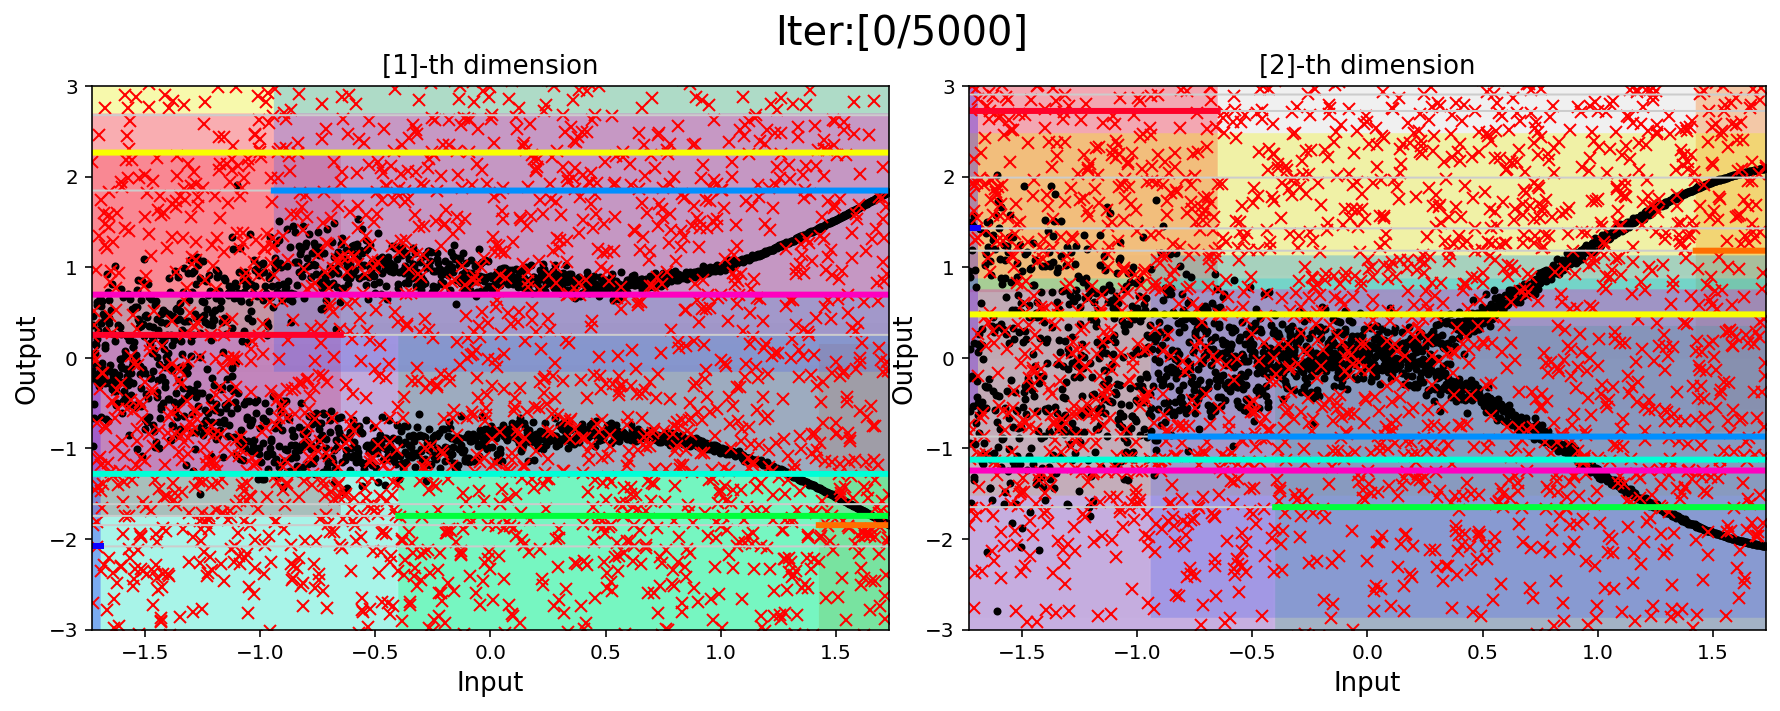

Iter:[100/5000] cost:[3.703].
Iter:[200/5000] cost:[2.342].
Iter:[300/5000] cost:[1.976].
Iter:[400/5000] cost:[1.708].
Iter:[500/5000] cost:[1.494].
Iter:[600/5000] cost:[1.361].
Iter:[700/5000] cost:[1.316].
Iter:[800/5000] cost:[0.896].
Iter:[900/5000] cost:[1.201].
Iter:[1000/5000] cost:[1.154].


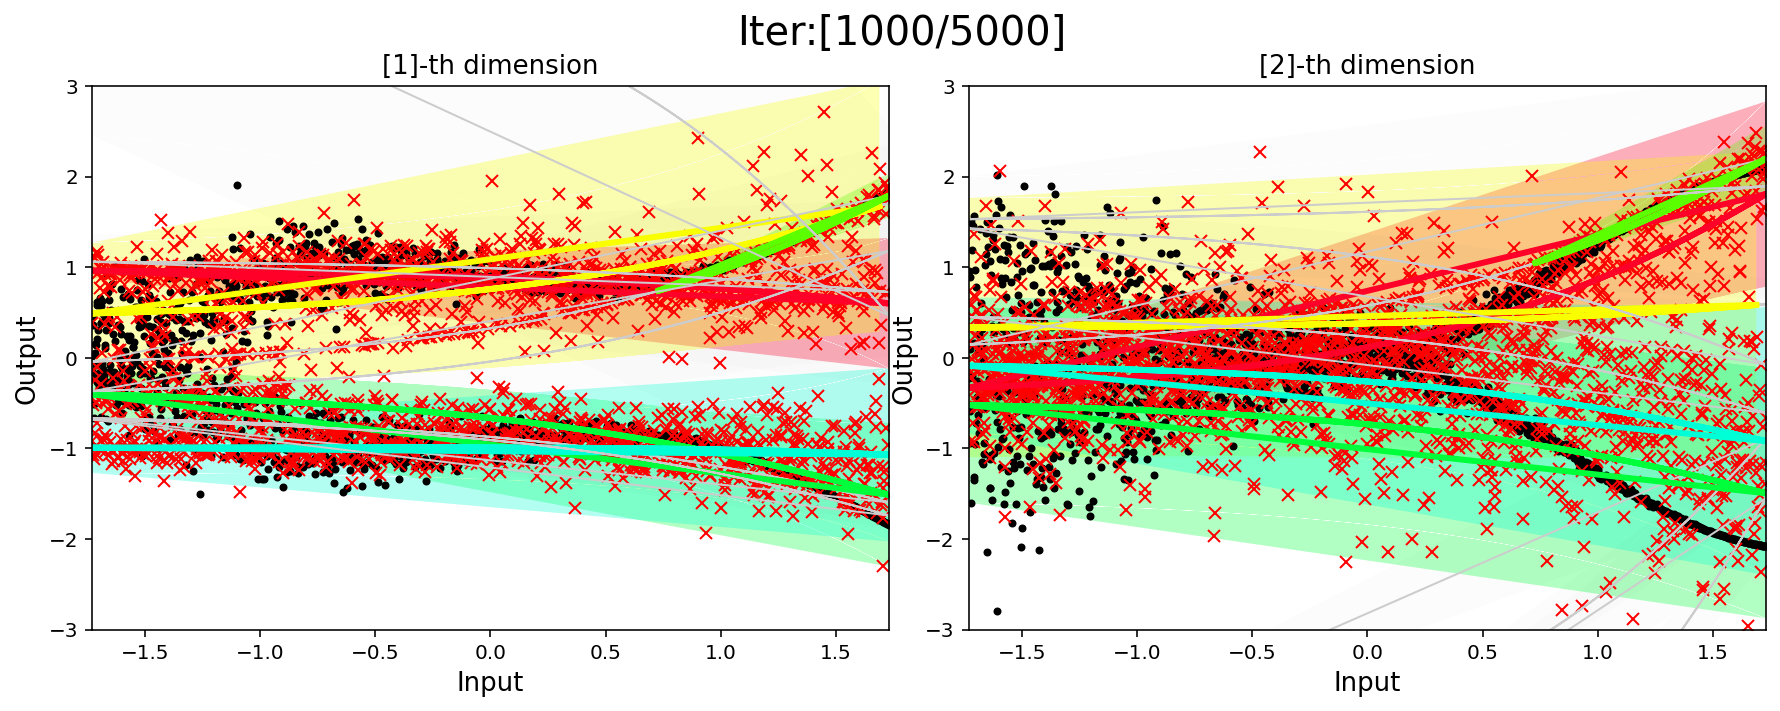

Iter:[1100/5000] cost:[1.133].
Iter:[1200/5000] cost:[0.979].
Iter:[1300/5000] cost:[0.737].
Iter:[1400/5000] cost:[0.644].
Iter:[1500/5000] cost:[0.739].
Iter:[1600/5000] cost:[0.511].
Iter:[1700/5000] cost:[0.588].
Iter:[1800/5000] cost:[0.406].
Iter:[1900/5000] cost:[0.648].
Iter:[2000/5000] cost:[0.278].


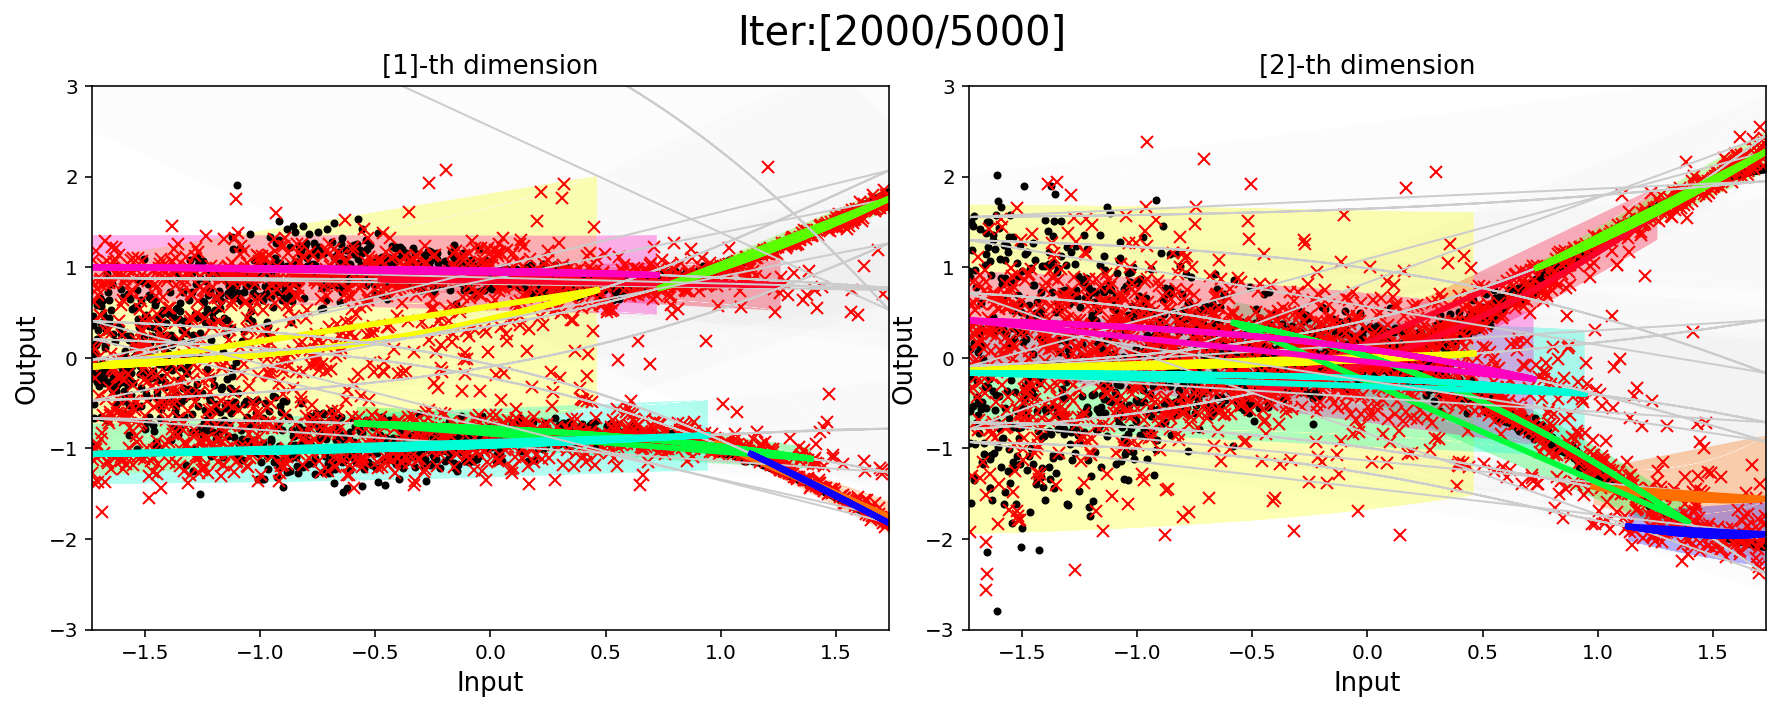

Iter:[2100/5000] cost:[0.333].
Iter:[2200/5000] cost:[-0.072].
Iter:[2300/5000] cost:[0.006].
Iter:[2400/5000] cost:[0.032].
Iter:[2500/5000] cost:[-0.124].
Iter:[2600/5000] cost:[0.154].
Iter:[2700/5000] cost:[-0.003].
Iter:[2800/5000] cost:[-0.605].
Iter:[2900/5000] cost:[0.272].
Iter:[3000/5000] cost:[-0.191].


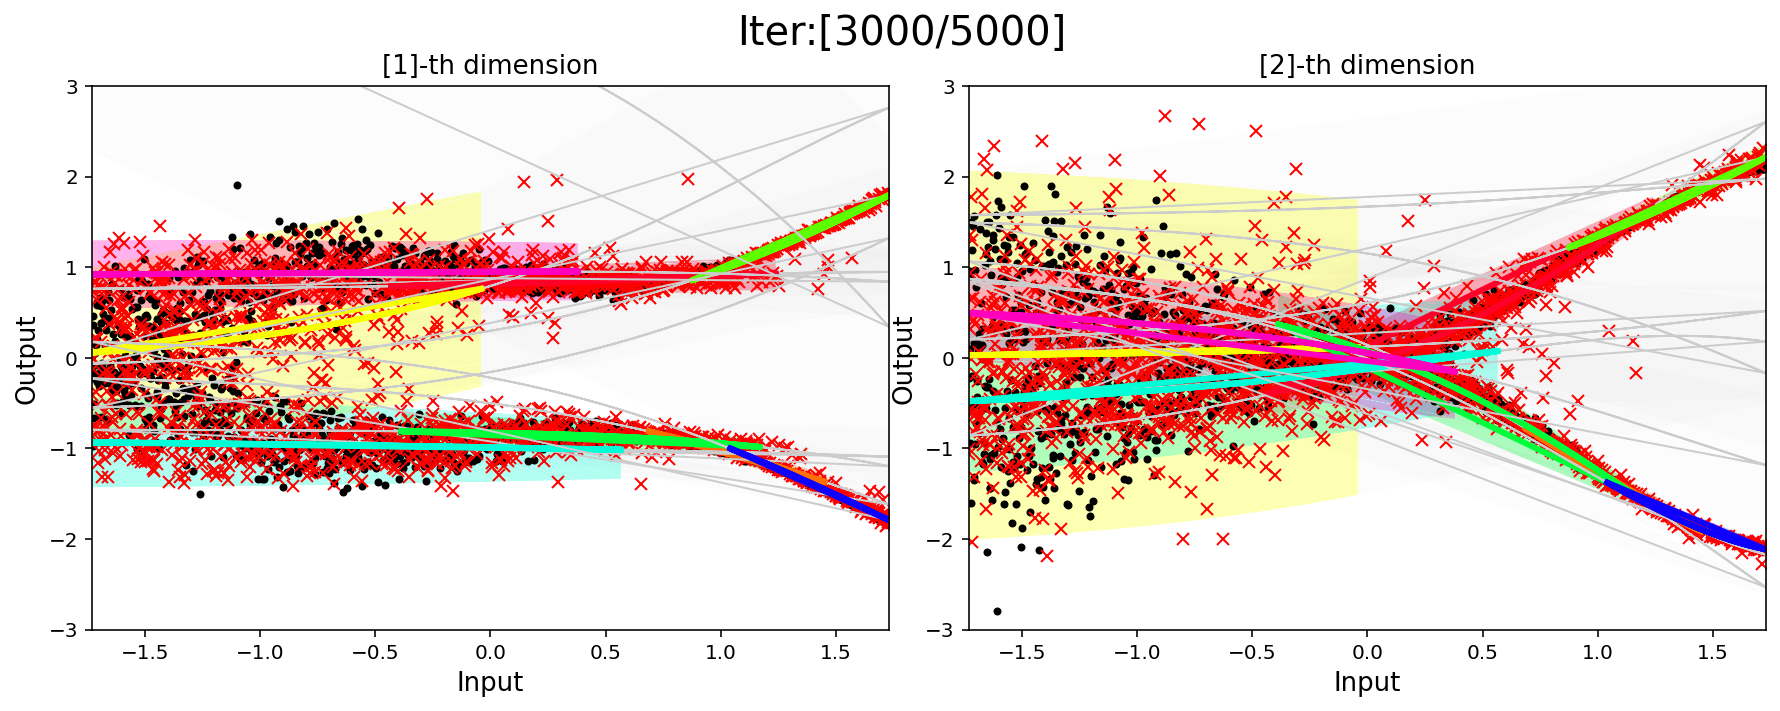

Iter:[3100/5000] cost:[-0.141].
Iter:[3200/5000] cost:[-0.378].
Iter:[3300/5000] cost:[-0.252].
Iter:[3400/5000] cost:[-0.222].
Iter:[3500/5000] cost:[-0.328].
Iter:[3600/5000] cost:[-0.332].
Iter:[3700/5000] cost:[-0.478].
Iter:[3800/5000] cost:[-0.288].
Iter:[3900/5000] cost:[-0.881].
Iter:[4000/5000] cost:[-0.410].


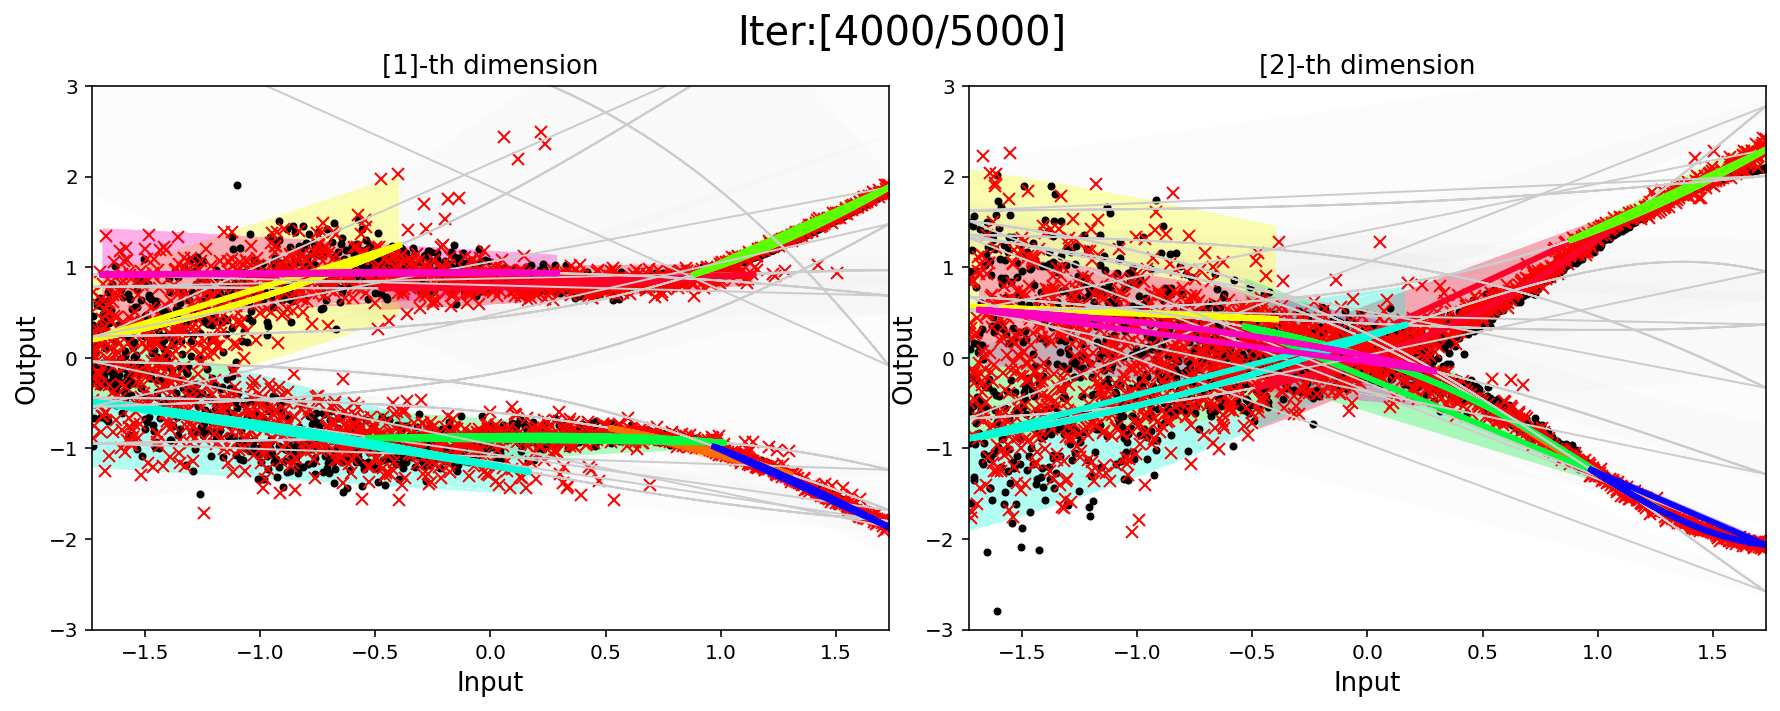

Iter:[4100/5000] cost:[-0.305].
Iter:[4200/5000] cost:[-0.372].
Iter:[4300/5000] cost:[-0.489].
Iter:[4400/5000] cost:[-0.728].
Iter:[4500/5000] cost:[-0.386].
Iter:[4600/5000] cost:[-0.385].
Iter:[4700/5000] cost:[-0.829].
Iter:[4800/5000] cost:[-0.653].
Iter:[4900/5000] cost:[-0.774].
Done.


In [5]:
max_iter,batch_size,print_every,plot_every = 5000,128,100,1000
for it in range(max_iter):
    r_idx = np.random.permutation(n)[:batch_size]
    x_batch,y_batch = x_train[r_idx,:],y_train[r_idx,:] # current batch
    cost_val = M.update(sess,x_batch,y_batch)
    
    if ((it%print_every)==0) or (iter==(max_iter-1)):
        print ("Iter:[%d/%d] cost:[%.3f]."%(it,max_iter,cost_val))
        
    if ((it%plot_every)==0) or (iter==(max_iter-1)):
        M.plot_test_result(
            sess,x_test=x_train,x_train=x_train,y_train=y_train,pi_th=0.1,
            ylim=[-3,+3],title_str='Iter:[%d/%d]'%(it,max_iter),tfs=20
        )
print ("Done.")